<a href="https://colab.research.google.com/github/jajapuramshivasai/QML-Molecular-Classification/blob/main/Quri_Quantum_Circuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explanation of Quantum Circuit Visualization and Trotterization

## Quantum Circuit Visualization

The quantum circuit visualization implemented in the `visualize_quantum_circuit` function is designed to represent the quantum circuit constructed for the QURI Ego-QW algorithm. This circuit operates on 5 qubits, corresponding to the nodes of a 5-node star graph's ego-subgraph centered at node 0 with radius 1. The visualization addresses the following key aspects:

- **Structure**: The circuit consists of horizontal wires representing qubits (|q0⟩ to |q4⟩), with gates applied sequentially along the x-axis. Each gate (e.g., Hadamard (H), Controlled-NOT (CNOT), Rotation around Z-axis (RZ)) is depicted as a colored box or symbol, with specific colors indicating gate types (e.g., H in green `#98D8C8`, CNOT in orange `#FFA07A`, RZ in teal `#4ECDC4`).

- **Initialization**: The circuit begins with Hadamard gates (H) applied to all 5 qubits to create a uniform superposition, as specified by the `init_mode="uniform"` configuration in the QURI Ego-QW setup.

- **Evolution**: The main body of the circuit implements a Trotterized evolution for one time step ($t=0.5$) over 4 edges $\{(0,1), (0,2), (0,3), (0,4)\}$. For each edge, the `edge_block` function applies an RXX gate (H, CNOT, RZ, CNOT, H) and an RYY gate (RZ(-$\pi$/2), H, CNOT, RZ(0.25), CNOT, H, RZ($\pi$/2)), totaling 17 gates per edge. With 4 edges, this results in 68 gates plus 5 initialization H gates, yielding 73 gates for one Trotter step.

- **Wrapping**: To prevent x-direction compression due to the large number of gates, the visualization wraps the circuit into multiple segments (approximately 7 segments with 12 gates per segment). Each segment is stacked vertically, with new qubit wires drawn and labeled (e.g., "Segment 1", "Segment 2"), ensuring readability.

- **Gate Handling**: The function maps QURI Parts' `QuantumGate` objects to visual representations by inspecting the `gate.operation.__class__.__name__` (e.g., 'HGate' to 'H'). Debug prints help identify gate types, addressing issues like the `gate_name` attribute error by adapting to the Rust backend's structure.

- **Output**: The resulting plot shows a multi-segment diagram with gates distributed across rows, maintaining a fixed width (14.4 units) per segment, and includes a title and qubit labels for clarity.

## Trotterization

Trotterization is a numerical technique used to approximate the time evolution of a quantum system under a time-dependent Hamiltonian, which is essential for the QURI Ego-QW algorithm's quantum walk simulation. Here's a detailed explanation:

- **Purpose**: In quantum mechanics, the time evolution of a quantum state $|\psi(t)\rangle$ is governed by the Schrödinger equation, $i\hbar \frac{d}{dt}|\psi(t)\rangle = H |\psi(t)\rangle$, where $H$ is the Hamiltonian. For a time-independent Hamiltonian, the evolution operator is $U(t) = e^{-iHt/\hbar}$. However, when $H$ is a sum of non-commuting terms (e.g., $H = H_1 + H_2$), computing $e^{-iHt/\hbar}$ directly is challenging. Trotterization approximates this by splitting the evolution into small time steps.

- **First-Order Trotter Approximation**: The Suzuki-Trotter formula approximates $e^{-i(H_1 + H_2)t}$ as:
  $$
  e^{-i(H_1 + H_2)t} \approx \left(e^{-iH_1 \Delta t} e^{-iH_2 \Delta t}\right)^{t/\Delta t} + O(\Delta t^2),
  $$
  where $\Delta t$ is a small time step, and the error is of order $\Delta t^2$. For multiple terms $H = \sum_i H_i$, the approximation extends to a product of exponentials for each term.

- **Application in QURI Ego-QW**: The QURI Ego-QW circuit models the quantum walk on a graph using a Hamiltonian derived from edge interactions. The Hamiltonian includes terms for edge couplings (e.g., RXX and RYY gates) and node potentials (e.g., RZ gates for labels, though zero here). The evolution is discretized into $N$ Trotter steps (here, $N = 4$) over a total time $t$ (e.g., 0.5 or 1.0), with each step applying $e^{-iH \Delta t}$ approximated as a sequence of gate operations:
  - $\Delta t = t / N$
  - For each edge $(i, j)$, the interaction is approximated by $e^{-i\gamma \Delta t (X_i X_j + Y_i Y_j)}$, implemented via RXX and RYY gates with angle $\phi = 2\gamma \Delta t$ (here, 0.25 for $t=0.5$, $\gamma=1.0$).
  - The process repeats $N$ times, refining the approximation.

- **Advantages**: Trotterization allows simulation on near-term quantum devices by breaking complex evolution into manageable gate sequences, suitable for the ego-subgraph's limited qubit count (5 here, up to 10 per `max_qubits_for_circuit`).

- **Limitations**: The approximation introduces errors that decrease with smaller $\Delta t$ (larger $N$), but increasing $N$ adds more gates, increasing circuit depth and noise on noisy intermediate-scale quantum (NISQ) devices. The QURI Ego-QW uses $N=4$, balancing accuracy and feasibility.

- **Context**: In the visualized circuit, one Trotter step (73 gates) represents a single application of the approximated evolution. The full simulation for $t=[0.5, 1.0]$ would repeat this 4 times per time, totaling 292 gates, though only one step is visualized for clarity.


In [1]:
# Install required packages
!pip install -q torch_geometric
!pip install -q networkx numpy scikit-learn matplotlib seaborn
!pip install -q "quri-parts[qulacs]"
!pip install -q requests tqdm

print("✓ Packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.8/585.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 46.1 MB/s eta 0:00:00
✓ Packages installed successfully!


#Input Graph

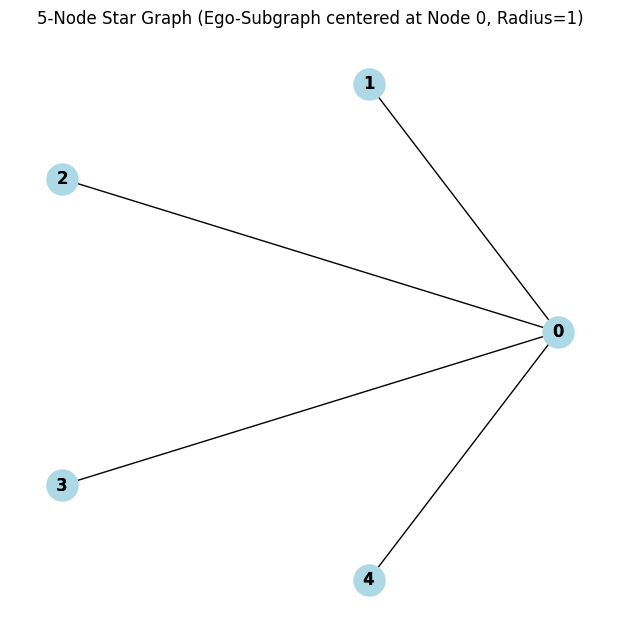

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the star graph
G = nx.star_graph(4)

# Plot the graph
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, font_weight='bold')
label_pos = {}
for node, coords in pos.items():
    label_pos[node] = (coords[0], coords[1] + 0.08)

nx.draw_networkx_labels(G, pos)
plt.title("5-Node Star Graph (Ego-Subgraph centered at Node 0, Radius=1)")
plt.show()

#Trotter Circuit with Quri

In [3]:
from quri_parts.circuit import QuantumCircuit
import math

# Helper functions from sub_main.ipynb
def add_H(circ, q):
    try:
        circ.add_H_gate(q)
    except Exception:
        circ.add_RY_gate(q, math.pi/2)
        circ.add_RZ_gate(q, math.pi)

def add_RZ(circ, q, angle):
    circ.add_RZ_gate(q, angle)

def add_CNOT(circ, c, t):
    circ.add_CNOT_gate(c, t)

def add_RXX(circ, a, b, phi):
    add_H(circ, a)
    add_H(circ, b)
    add_CNOT(circ, a, b)
    add_RZ(circ, b, phi)
    add_CNOT(circ, a, b)
    add_H(circ, a)
    add_H(circ, b)

def add_RYY(circ, a, b, phi):
    add_RZ(circ, a, -math.pi/2)
    add_RZ(circ, b, -math.pi/2)
    add_H(circ, a)
    add_H(circ, b)
    add_CNOT(circ, a, b)
    add_RZ(circ, b, phi)
    add_CNOT(circ, a, b)
    add_H(circ, a)
    add_H(circ, b)
    add_RZ(circ, a, math.pi/2)
    add_RZ(circ, b, math.pi/2)

def edge_block(circ, i, j, phi):
    add_RXX(circ, i, j, phi)
    add_RYY(circ, i, j, phi)

# Circuit parameters
n = 5
edges = [(0, 1), (0, 2), (0, 3), (0, 4)]
t = 0.5
trotter_steps = 4
gamma = 1.0
dt = t / trotter_steps
phi_base = 2.0 * gamma * dt
init_mode = "uniform"

# Create quantum circuit
circ = QuantumCircuit(n)

# Initialization
if init_mode == "uniform":
    for q in range(n):
        add_H(circ, q)

# One Trotter step
for (i, j) in edges:
    edge_block(circ, i, j, phi_base)

#Quantum Circuit Visualization

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch

def visualize_quantum_circuit(circuit, n_qubits, gates_per_row=15, save_path=None):
    """Enhanced quantum circuit visualization with wrapping."""
    total_gates = len(circuit.gates)
    num_rows = (total_gates + gates_per_row - 1) // gates_per_row # Calculate number of rows

    fig, axes = plt.subplots(num_rows, 1, figsize=(20, max(8, n_qubits * 1.2) * num_rows), squeeze=False)

    for row_idx in range(num_rows):
        ax = axes[row_idx, 0]
        start_gate_idx = row_idx * gates_per_row
        end_gate_idx = min((row_idx + 1) * gates_per_row, total_gates)
        current_gates = circuit.gates[start_gate_idx:end_gate_idx]

        # Draw qubit wires
        for i in range(n_qubits):
            ax.plot([0, gates_per_row * 2], [n_qubits - 1 - i, n_qubits - 1 - i], 'k-', linewidth=2, alpha=0.6)
            if row_idx == 0: # Only add qubit labels on the first row
                 ax.text(-0.5, n_qubits - 1 - i, f'|q{i}⟩', fontsize=13, ha='right', va='center',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))


        # Gate colors
        gate_colors = {'RY': '#FF6B6B', 'RZ': '#4ECDC4', 'RX': '#45B7D1', 'CNOT': '#FFA07A', 'H': '#98D8C8'}

        gate_positions = [0] * n_qubits

        for gate_idx, gate in enumerate(current_gates):
            gate_name = gate.name
            target_indices = gate.target_indices
            control_indices = getattr(gate, 'control_indices', ())

            affected_qubits = list(target_indices) + list(control_indices)
            max_pos = max(gate_positions[q] for q in affected_qubits)

            pos = max_pos + 1

            if gate_name in ['RY', 'RZ', 'RX', 'H']:
                for target in target_indices:
                    y_pos = n_qubits - 1 - target
                    color = gate_colors.get(gate_name, 'lightgray')
                    rect = FancyBboxPatch(
                        (pos - 0.4, y_pos - 0.35), 0.8, 0.7,
                        boxstyle="round,pad=0.05", facecolor=color, edgecolor='black', linewidth=2.5
                    )
                    ax.add_patch(rect)
                    ax.text(pos, y_pos, gate_name, ha='center', va='center', fontsize=10, color='black')
                    gate_positions[target] = pos + 1.0

            elif gate_name == 'CNOT':
                control = control_indices[0]
                target = target_indices[0]
                y_control = n_qubits - 1 - control
                y_target = n_qubits - 1 - target
                ax.plot([pos, pos], [y_control, y_target], 'k-', linewidth=2)
                ax.add_patch(plt.Circle((pos, y_control), 0.1, color='black', fill=True))
                ax.add_patch(Rectangle((pos - 0.2, y_target - 0.2), 0.4, 0.4, facecolor=gate_colors['CNOT'], edgecolor='black'))
                ax.text(pos, y_target, 'X', ha='center', va='center', fontsize=10, color='black')
                gate_positions[control] = pos + 1.0
                gate_positions[target] = pos + 1.0


        ax.set_xlim(-1, gates_per_row *1.45)
        ax.set_ylim(-1, n_qubits)
        ax.set_yticks([])
        ax.set_xticks([])
        if row_idx == 0:
            ax.set_title("Quantum Circuit for QURI Ego-QW (5 Qubits, 1 Trotter Step, t=0.5)", fontsize=14)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


#plot

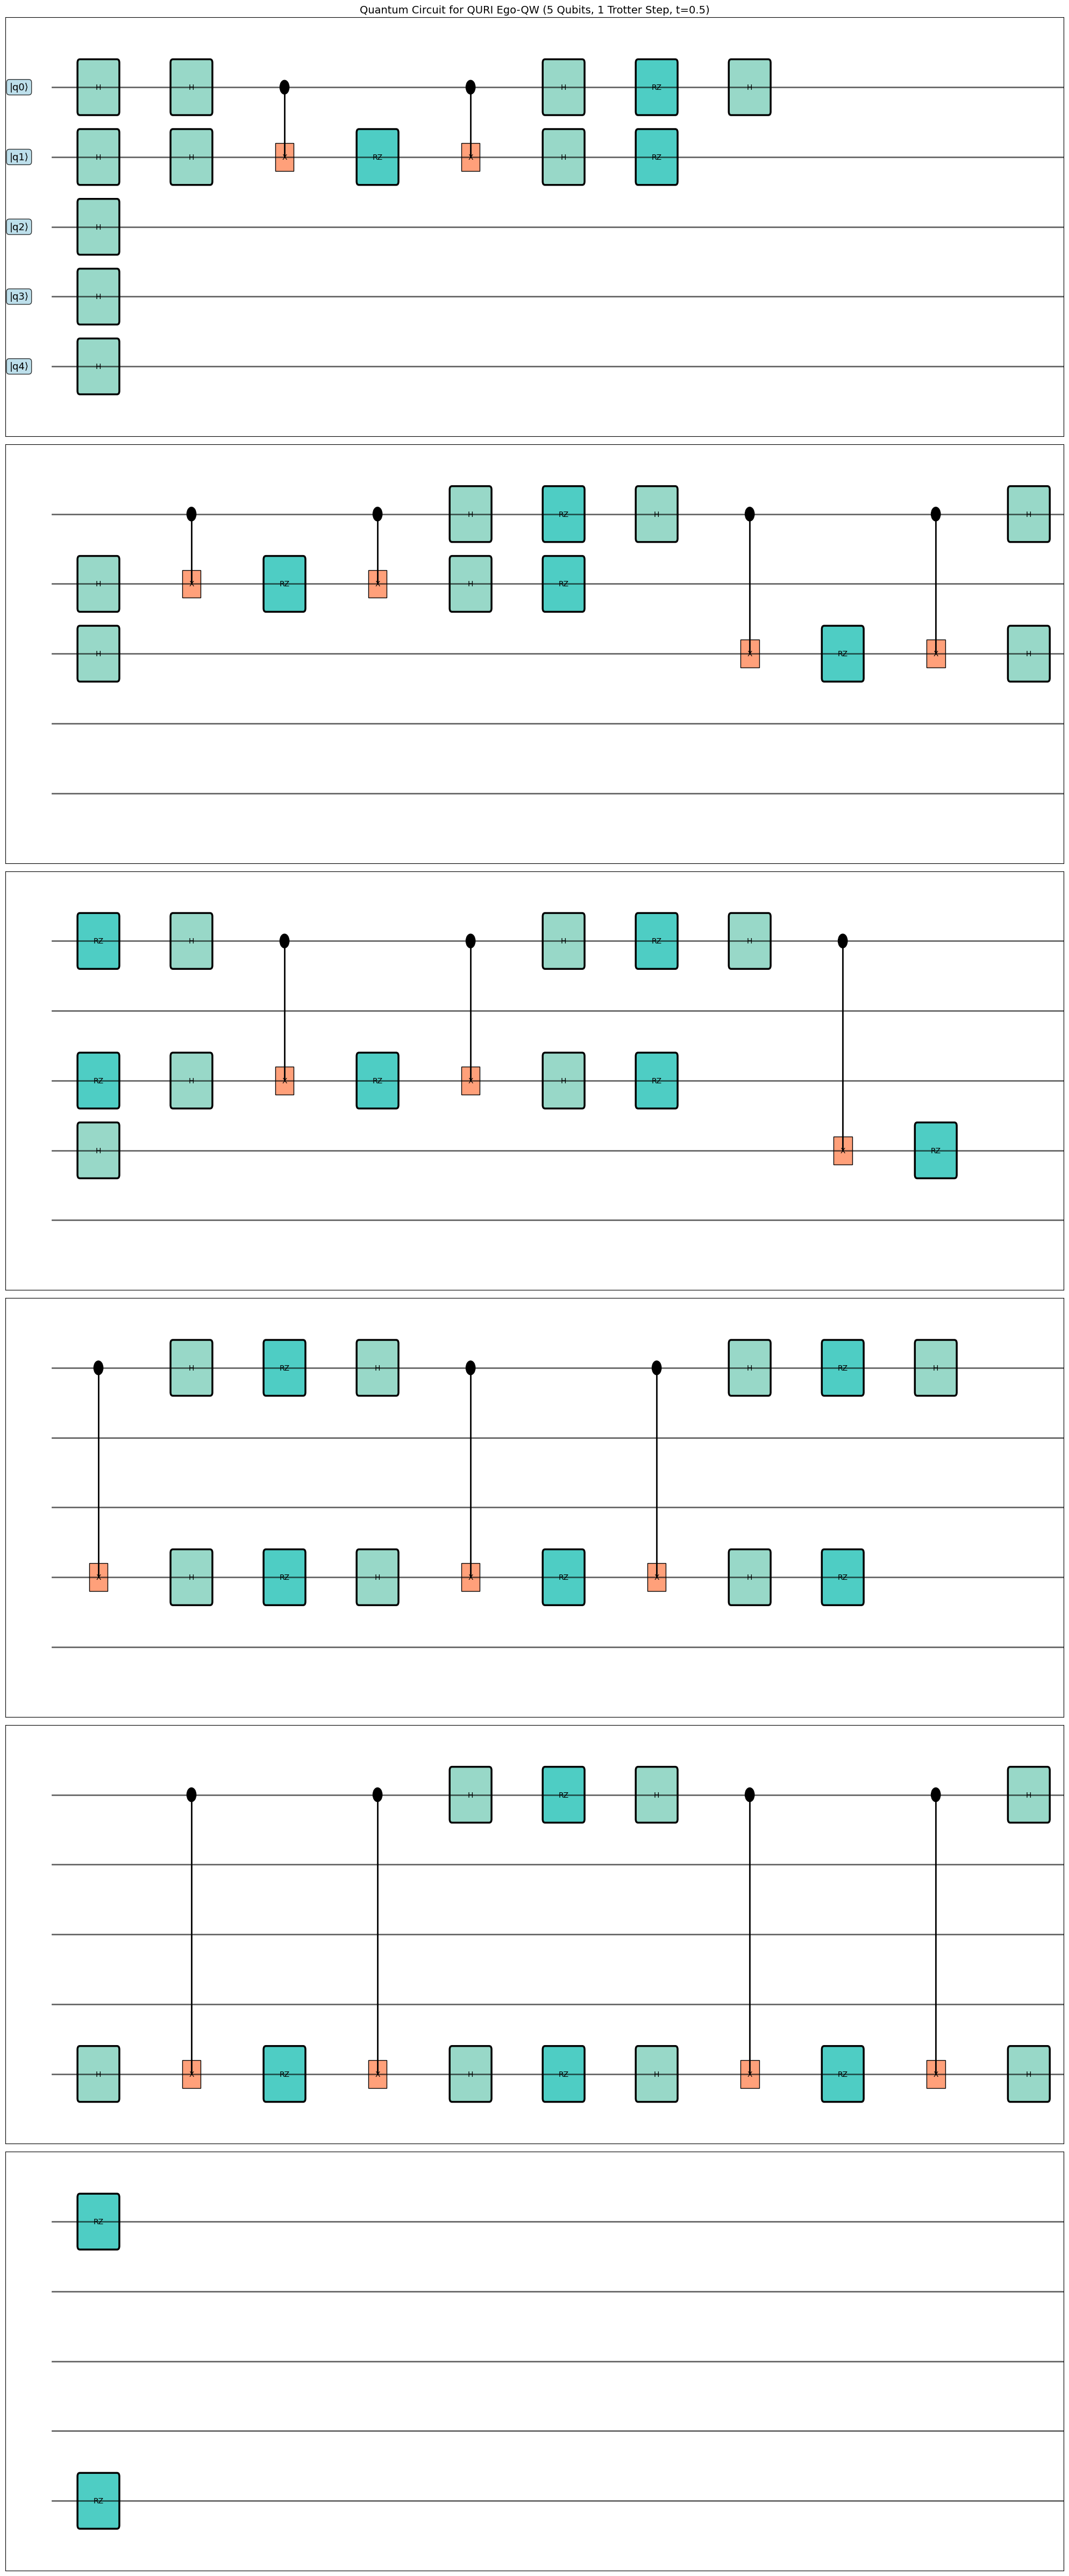

In [5]:
visualize_quantum_circuit(circ, n_qubits=5, gates_per_row=15)